# 2D SSN Model

In this notebook:
- training script for SSN model
- implementation of vmap
- new parameter added for extra synaptic GABA
- storing accuracy and params in csv file
- function to plot csv file data

Imports

In [1]:
import matplotlib.pyplot as plt
import time, os, json
import pandas as pd
from scipy import stats 
from tqdm import tqdm
import seaborn as sns
import jax
from jax import random
from jax.config import config 
import jax.numpy as np
from jax import vmap
import pdb
import optax
import csv
import time
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import numpy


#config.update('jax_debug_nans', True)
from SSN_classes_jax import SSN2DTopoV1_AMPAGABA_ONOFF
from util import GaborFilter, BW_Grating, find_A, create_gabor_filters, create_gratings

#initialize key
key = random.PRNGKey(9)

### Parameters to define

1. STIMULI PARAMETERS

In [2]:
#Gabor parameters 
sigma_g= 0.5
k = np.pi/(6*sigma_g)

#Stimuli parameters
ref_ori = 55
offset = 5

#Assemble parameters in dictionary
general_pars = dict(k=k , edge_deg=3.2,  degree_per_pixel=0.05)
stimuli_pars = dict(outer_radius=3, inner_radius=2.5, grating_contrast=0.8, std = 15, jitter_val = 5, snr = 1)
stimuli_pars.update(general_pars)

2. MODEL PARAMETERS

In [3]:
#Network parameters
class ssn_pars():
    n = 2
    k = 0.04
    tauE = 30 # in ms
    tauI = 10 # in ms~
    psi = 0.774
    tau_s = np.array([5, 7, 100]) #in ms, AMPA, GABA, NMDA current decay time constants
    

#Grid parameters
class grid_pars():
    gridsize_Nx = 9 # grid-points across each edge # gives rise to dx = 0.8 mm
    gridsize_deg = 2 * 1.6 # edge length in degrees
    magnif_factor = 2  # mm/deg
    hyper_col = 0.8 # mm   
    sigma_RF = 0.4 # deg (visual angle)

# Caleb's params for the full (with local) model:
Js0 = [1.82650658, 0.68194475, 2.06815311, 0.5106321]
gE, gI = 0.57328625, 0.26144141

sigEE, sigIE = 0.2, 0.40
sigEI, sigII = .09, .09
conn_pars = dict(
    PERIODIC = False,
    p_local = [.4, 0.7], # [p_local_EE, p_local_IE],
    sigma_oris = 1000) # sigma_oris


make_J2x2 = lambda Jee, Jei, Jie, Jii: np.array([[Jee, -Jei], [Jie,  -Jii]]) * np.pi * ssn_pars.psi
J_2x2 = make_J2x2(*Js0)
s_2x2 = np.array([[sigEE, sigEI],[sigIE, sigII]])

#Positive reparameterization
signs=np.array([[1, -1], [1, -1]])
logJ_2x2 =np.log(J_2x2*signs)
logs_2x2 = np.log(s_2x2)


#Sigmoid parameters~
N_neurons = 25

key, _ = random.split(key)
w_sig = random.normal(key, shape = (N_neurons,)) / np.sqrt(N_neurons)
b_sig = 0.0

#Excitatory and inhibitory constants for extra synaptic GABA
c_E = 1.0
c_I = 1.0

#Optimization pars
opt_pars = dict(logJ_2x2 = logJ_2x2, logs_2x2 = logs_2x2, w_sig = w_sig, b_sig=b_sig, c_E = c_E, c_I = c_I)


#Parameters exclusive to Gabor filters
filter_pars = dict(sigma_g = sigma_g, conv_factor = grid_pars.magnif_factor)
filter_pars.update(general_pars) 

#Convergence parameters
conv_pars=dict(dt = 1, xtol = 1e-5, Tmax = 200, verbose=False, silent=True)


3. TRAINING PARAMETERS

In [4]:
#Name of results csv
home_dir = os.getcwd()
#Create directory for results
results_dir = os.path.join(home_dir, 'results')
if os.path.exists(results_dir) == False:
        os.makedirs(results_dir)
        
        
results_name = None #SPECIFY NAME OF RESULTS FILE
if results_name == None:
    results_name = 'results_test2.csv'

results_filename = os.path.join(results_dir, results_name)

#Number of epochs
epochs = 5
num_epochs_to_save = 3
epochs_to_save = np.linspace(1 ,epochs, num_epochs_to_save).astype(int)


## TRAINING

In [5]:
def create_data(stimuli_pars, number=100, offset = 5, ref_ori=55):
    
    '''
    Create data for given jitter and snr value for testing (not dataloader)
    '''
    data = create_gratings(ref_ori=ref_ori, number=number, offset=offset, **stimuli_pars)
    train_data = next(iter(DataLoader(data, batch_size=len(data), shuffle=False)))
    train_data['ref'] = train_data['ref'].numpy()
    train_data['target'] = train_data['target'].numpy()
    train_data['label'] = train_data['label'].numpy()
    
    return train_data

def save_params(all_J, all_s, all_c, params, count):

    all_J[0, count] = np.exp(params['logJ_2x2'][0,0]) #J_EE
    all_J[1, count] = np.exp(params['logJ_2x2'][0,1])*-1 #J_EI
    all_J[2, count] = np.exp(params['logJ_2x2'][1,0]) #J_IE
    all_J[3, count] = np.exp(params['logJ_2x2'][1,1])*-1 #J_II
    
    all_s[0, count] = params['logs_2x2'][0,0] #s_EE
    all_s[1, count] = params['logs_2x2'][0,1] #s_EI
    all_s[2, count] = params['logs_2x2'][1,0] #s_IE
    all_s[3, count] = params['logs_2x2'][1,1] #s_II
    
    all_c[0, count] = params['c_E']
    all_c[1, count] = params ['c_I']

    count +=1
    
    return all_J,all_s, all_c, count

def constant_to_vec(c_E, c_I):
    
    matrix_E = np.zeros((9,9))
    matrix_E = matrix_E.at[2:7, 2:7].set(c_E)
    vec_E = np.ravel(matrix_E)
    
    matrix_I = np.zeros((9,9))
    matrix_I = matrix_I.at[2:7, 2:7].set(c_I)
    vec_I = np.ravel(matrix_I)
    
    constant_vec = np.hstack((vec_E, vec_E, vec_I, vec_I))
    return constant_vec

def sigmoid(x):
    return 1/(1+np.exp(x))

def binary_loss(n, x):
    return - (n*np.log(x) + (1-n)*np.log(1-x))

def model(opt_pars, ssn_pars, grid_pars, conn_pars, train_data, filter_pars,  conv_pars):
    
    signs=np.array([[1, -1], [1, -1]])
    
    J_2x2 =np.exp(opt_pars['logJ_2x2'])*signs
    s_2x2 = np.exp(opt_pars['logs_2x2'])
    
    #Initialise network
    ssn=SSN2DTopoV1_AMPAGABA_ONOFF(ssn_pars=ssn_pars, grid_pars=grid_pars, conn_pars=conn_pars, filter_pars=filter_pars, J_2x2=J_2x2, s_2x2=s_2x2)
    
    #Create vector using extrasynaptic constants
    constant_vector = constant_to_vec(opt_pars['c_E'], opt_pars['c_I'])
    
    #Apply Gabor filters to stimuli
    output_ref=np.matmul(ssn.gabor_filters, train_data['ref'])*ssn.A + constant_vector
    output_target=np.matmul(ssn.gabor_filters, train_data['target'])*ssn.A + constant_vector
    

    #Rectify output
    SSN_input_ref=np.maximum(0, output_ref)
    SSN_input_target=np.maximum(0, output_target)

    #Input to SSN
    r_init = np.zeros(SSN_input_ref.shape[0])

    fp_ref, _ = ssn.fixed_point_r(SSN_input_ref, r_init=r_init, **conv_pars)
    x_ref = ssn.apply_bounding_box(fp_ref, size=3.2)

    fp_target, _ = ssn.fixed_point_r(SSN_input_target, r_init=r_init, **conv_pars)
    x_target = ssn.apply_bounding_box(fp_target, size=3.2)

    #Apply sigmoid function - combine ref and target
    x = sigmoid( np.dot(opt_pars['w_sig'], (x_ref.ravel() - x_target.ravel())) + opt_pars['b_sig'])

    #Calculate binary cross entropy loss
    loss=binary_loss(train_data['label'], x)
   
    return loss


def loss(opt_pars, ssn_pars, grid_pars, conn_pars, train_data, filter_pars,  conv_pars):
    '''
    Calculate parallelized loss for batch of data through vmap.
    Output:
        mean loss of all the input images
    '''
    
    vmap_model = vmap(model, in_axes = ({'b_sig': None, 'c_E':None, 'c_I': None, 'logJ_2x2': None, 'logs_2x2': None, 'w_sig': None}, None, None, {'PERIODIC': None, 'p_local': [None, None], 'sigma_oris': None},  {'ref':0, 'target':0, 'label':0}, {'conv_factor': None, 'degree_per_pixel': None, 'edge_deg': None, 'k': None, 'sigma_g': None}, {'Tmax': None, 'dt': None, 'silent': None, 'verbose': None, 'xtol': None}) )                   
    loss = np.sum(vmap_model(opt_pars, ssn_pars, grid_pars, conn_pars, train_data, filter_pars,  conv_pars))

    return loss




def eval_model(opt_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars):
    signs=np.array([[1, -1], [1, -1]])
    
    J_2x2 =np.exp(opt_pars['logJ_2x2'])*signs
    s_2x2 = np.exp(opt_pars['logs_2x2'])
    
    #Initialise network
    ssn=SSN2DTopoV1_AMPAGABA_ONOFF(ssn_pars=ssn_pars, grid_pars=grid_pars, conn_pars=conn_pars, filter_pars=filter_pars, J_2x2=J_2x2, s_2x2=s_2x2)

    #Apply Gabor filters to stimuli
    output_ref=np.matmul(ssn.gabor_filters, test_data['ref'])*ssn.A
    output_target=np.matmul(ssn.gabor_filters, test_data['target'])*ssn.A

    #Rectify output
    SSN_input_ref=np.maximum(0, output_ref)
    SSN_input_target=np.maximum(0, output_target)

    #Input to SSN
    r_init = np.zeros(SSN_input_ref.shape[0])

    fp_ref, _ = ssn.fixed_point_r(SSN_input_ref, r_init=r_init, **conv_pars)
    x_ref = ssn.apply_bounding_box(fp_ref, size=3.2)

    fp_target, _ = ssn.fixed_point_r(SSN_input_target, r_init=r_init, **conv_pars)
    x_target = ssn.apply_bounding_box(fp_target, size=3.2)
    
    dot= np.dot(opt_pars['w_sig'], (x_ref.ravel() - x_target.ravel()))

    #Apply sigmoid function - combine ref and target
    x = sigmoid( np.dot(opt_pars['w_sig'], (x_ref.ravel() - x_target.ravel())) + opt_pars['b_sig'])
    
    #compare prediction to label
    pred_label = np.round(x)

    #Calculate binary cross entropy loss
    loss=binary_loss(test_data['label'], x)
    
    return loss, pred_label, x


def vmap_eval(opt_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars):
    
    eval_vmap = vmap(eval_model, in_axes = ({'b_sig': None,  'c_E':None, 'c_I': None,  'logJ_2x2': None, 'logs_2x2': None, 'w_sig': None}, None, None, {'PERIODIC': None, 'p_local': [None, None], 'sigma_oris': None},  {'ref':0, 'target':0, 'label':0}, {'conv_factor': None, 'degree_per_pixel': None, 'edge_deg': None, 'k': None, 'sigma_g': None}, {'Tmax': None, 'dt': None, 'silent': None, 'verbose': None, 'xtol': None}) )
    losses, pred_labels, dots = eval_vmap(opt_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars)
    
    accuracy = np.sum(test_data['label'] == pred_labels)/len(test_data['label']) 
    
    vmap_loss= np.mean(losses)
    
    return vmap_loss, accuracy, dots


def train_SSN_vmap(opt_pars, ssn_pars, grid_pars, conn_pars, stimuli_pars, filter_pars, conv_pars, results_filename, epochs_to_save, batch_size=20, ref_ori = 55, offset = 5, epochs=1, eta=10e-4):
    
    #Initialize loss
    val_loss_per_epoch = []
    training_losses=[]
    accuracies=[]
        
    #Initialise optimizer
    optimizer = optax.adam(eta)
    opt_state = optimizer.init(opt_pars)
    
    #Define test data - no need to iterate
    test_data = create_data(stimuli_pars, number = batch_size, offset = offset, ref_ori = ref_ori)
    val_loss, accuracy, _= vmap_eval(opt_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars)
    print('Before training  -- loss: {}, accuracy: {} '.format(val_loss, accuracy))
    val_loss_per_epoch.append(val_loss)
    accuracies.append(accuracy)
    
    results_handle = open(results_filename, 'w')
    results_writer=None

    
    for epoch in range(1, epochs+1):
        start_time = time.time()
        epoch_loss = 0 
           
        #load next batch of data and convert
        train_data = create_data(stimuli_pars, number = batch_size, offset = offset, ref_ori = ref_ori)

        #Compute loss and gradient
        epoch_loss, grad =jax.value_and_grad(loss)(opt_pars, ssn_pars, grid_pars, conn_pars, train_data, filter_pars,  conv_pars)

        #Apply SGD through Adam optimizer per batch
        updates, opt_state = optimizer.update(grad, opt_state)
        opt_pars = optax.apply_updates(opt_pars, updates)
        training_losses.append(epoch_loss)
        
        epoch_time = time.time() - start_time

        #Save the parameters given a number of epochs
        if epoch in epochs_to_save:
            
            #Evaluate model 
            test_data = create_data(stimuli_pars, number = batch_size, offset = offset, ref_ori = ref_ori)
            val_loss, accuracy, _= vmap_eval(opt_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars)
            print('Training loss: {} ¦ Validation -- loss: {}, accuracy: {} at epoch {}, (time {})'.format(epoch_loss, val_loss, accuracy, epoch, epoch_time))
            val_loss_per_epoch.append(val_loss)
            accuracies.append(accuracy)
            
            #Create dictionary to save desired params
            save_params= dict(val_accuracy= accuracy, 
                J_EE= opt_pars['logJ_2x2'][0,0], J_EI = opt_pars['logJ_2x2'][0,1], 
                              J_IE = opt_pars['logJ_2x2'][0,0], J_II = opt_pars['logJ_2x2'][0,0], 
                s_EE= opt_pars['logs_2x2'][0,0], s_EI = opt_pars['logs_2x2'][0,1], 
                              s_IE = opt_pars['logJ_2x2'][0,0], s_II = opt_pars['logJ_2x2'][0,0],
                c_E = opt_pars['c_E'], c_I = opt_pars['c_I'], 
                 epoch = epoch)
            
            #Only write header once
            if results_writer is None:
                results_writer = csv.DictWriter(results_handle, fieldnames=save_params.keys())
                results_writer.writeheader()
            
            #Write results in csv file
            results_writer.writerow(save_params)
         
    
    #Reparametize parameters
    signs=np.array([[1, -1], [1, -1]])    
    opt_pars['logJ_2x2'] = np.exp(opt_pars['logJ_2x2'])*signs
    opt_pars['logs_2x2'] = np.exp(opt_pars['logs_2x2'])
    
   
    return opt_pars, val_loss_per_epoch, training_losses

In [6]:
final_pars, val_loss, training_loss = train_SSN_vmap(opt_pars, ssn_pars, grid_pars, conn_pars, stimuli_pars, filter_pars,  conv_pars, results_filename, epochs_to_save = epochs_to_save, ref_ori = 55, offset = 2, batch_size = 50, epochs = epochs)

Before training  -- loss: 0.9260391592979431, accuracy: 0.07999999821186066 
Training loss: 49.27684783935547 ¦ Validation -- loss: 0.9961494207382202, accuracy: 0.05999999865889549 at epoch 1, (time 8.63299036026001)
Training loss: 47.22557067871094 ¦ Validation -- loss: 0.9734833240509033, accuracy: 0.18000000715255737 at epoch 3, (time 6.8098390102386475)
Training loss: 46.42369842529297 ¦ Validation -- loss: 0.8648292422294617, accuracy: 0.14000000059604645 at epoch 5, (time 6.564150810241699)


## PLOT RESULTS

In [7]:
def plot_results(results_file):
    
    results = pd.read_csv(results_file, header = 0)
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

    results.plot(x='epoch', y=["J_EE", "J_EI", "J_IE", "J_EE"], ax=axes[0,0])
    results.plot(x='epoch', y=["s_EE", "s_EI", "s_IE", "s_EE"], ax = axes[0,1])
    results.plot(x='epoch', y=["c_E", "c_I"], ax = axes[1,0])
    results.plot(x='epoch', y = 'val_accuracy', ax = axes[1,1])

    fig.show()

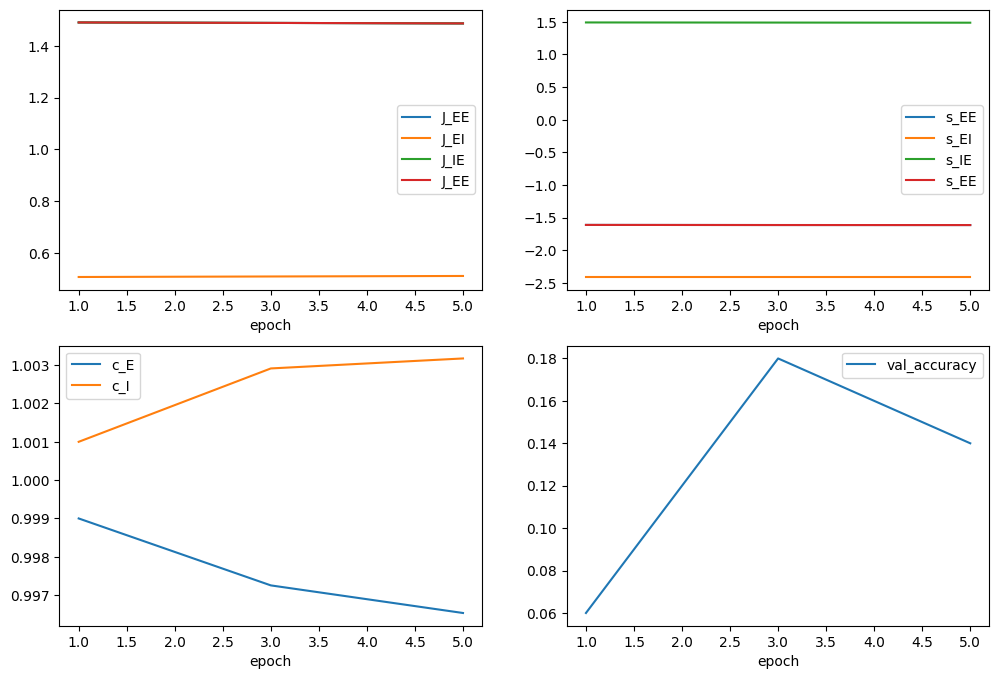

In [9]:
plot_results(results_filename)